## NOTES
1. need to filter out overlapping predicted bboxs before mAP metrics evaluation??
    - YES! you need to do NMS to remove highly overlapping bboxs (see ```show_preds``` near ```process_output``` from fastai notebook [pascal.ipynb](https://github.com/fastai/course-v3/blob/master/nbs/dl2/pascal.ipynb))
    - In summary the following procedures are needed: 
        - (i) process_output on predictions (for each sample) -- ```process_output```
        - (ii) NMS on predicted bbox and scores -- ```nms```
        - (iii) bbox from CTHW to TLBR format
2. Following up on above, why ```unpad``` is not used (on target bbox and labels)??
3. CTHW really refer H to Height, W to Width? (Why not CTWH)
    - YES! CT = (y, x), HW = (height, width)
4. TLBR is [x0, y0, x1, y1] OR [y0, x0, y1, x1]??
    - [y0, x0, y1, x1]!! Top-Left-Bottom-Right
5. TensorBBox after DataLoaders is in [x0, y0, x1, y1] OR [y0, x0, y1, x1]??

In [1]:
import os
import sys
path = os.path.join(os.getcwd(), '..')
sys.path.append(path)

from pathlib import Path
from pdb import set_trace
import warnings
warnings.filterwarnings('ignore')

from fastai2.vision.all import *

from src.data.dblock import build_dblock
from src.data.dls import build_dataloaders
from src.model.model import get_retinanet, split_param_groups
from src.metrics.loss import get_retinanet_loss
from src.metrics.mAP import mAP

%load_ext autoreload
%autoreload 2

### 0. Setup Learner

In [2]:
data_path = Path('/userhome/34/h3509807/wheat-data')
model_path = Path('/userhome/34/h3509807/Wheat-Detection-2020')

dls = build_dataloaders(data_path, bs = 8, 
                        resize_sz = 256, norm = True, 
                        rand_seed = 144, test_mode = True)

len(dls.train.items), len(dls.valid.items)

(96, 24)

In [3]:
model = get_retinanet()
retinanet_loss = get_retinanet_loss(ratios = None, scales = None)
learn = Learner(dls, model, path = model_path,
                loss_func = retinanet_loss,
                splitter = split_param_groups)

In [4]:
learn.load('final_retinanet_learner')

### 1. Get Model Prediction

In [5]:
b = learn.dls.one_batch()

learn.model.eval()
with torch.no_grad():
    preds = learn.model(b[0])

### 2. Interface Prediction with mAP Metrics

In [6]:
from src.metrics.utils import create_anchors, activ_to_bbox
from src.metrics.utils import tlbr2cthw, cthw2tlbr

In [7]:
def test_process_output(output, i, detect_thresh=0.25):
    """ 
    Process `output[i]` and return the predicted bboxes above `detect_thresh`.
    
    :return:
        bbox_pred : bbox in normalized cthw format
        scores : confidence score after filtering
        preds : class index for a predicted bbox
    """
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    
    scales = [1, 2**(-1/3), 2**(-2/3)]
    ratios = [1/2, 1, 2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    
    # argmax --> sigmoid(.) --> apply threshold
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    
    # still expressed in cthw 
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

### 2a. From BBox Offset (bbox_pred) to BBox CTHW (p_bbox_pred)
- bbox_pred is in batch
- p_bbox_pred is in one sample

In [8]:
clas_pred, bbox_pred, sizes = preds

bbox_pred.shape, bbox_pred[0, :3]

(torch.Size([8, 46836, 4]),
 tensor([[ 2.7702,  2.3190, -2.5950, -4.2631],
         [ 3.4405,  2.3720, -1.9179, -4.2507],
         [ 2.9377,  2.9003, -1.5436, -4.2135]], device='cuda:0'))

In [41]:
p_bbox_pred, p_scores, p_preds = test_process_output(preds, 0, detect_thresh = 0.5)
p_bbox_pred.shape

torch.Size([46584, 4])

In [10]:
p_bbox_pred[:3]

tensor([[-0.9016, -0.8319,  0.1968,  0.3362],
        [-0.9108, -0.8622,  0.1785,  0.2757],
        [-0.9307, -0.8777,  0.1387,  0.2447]], device='cuda:0')

### 2b. Rescale BBox CTHW (p_bbox_pred) to BBox TLBR (tlbr_bbox_pred)
- both p_bbox_pred, tlbr_bbox_pred is in one sample

In [11]:
from src.metrics.utils import cthw2tlbr

In [12]:
test_cthw_bbox = torch.as_tensor([[-0., -0., 0.5, 0.5]])
cthw2tlbr(test_cthw_bbox)

tensor([[-0.2500, -0.2500,  0.2500,  0.2500]])

In [13]:
tlbr_bbox_pred = cthw2tlbr(p_bbox_pred)
tlbr_bbox_pred.shape, tlbr_bbox_pred[:3]

(torch.Size([46584, 4]),
 tensor([[-1.0000, -1.0000, -0.8032, -0.6638],
         [-1.0000, -1.0000, -0.8215, -0.7243],
         [-1.0000, -1.0000, -0.8613, -0.7553]], device='cuda:0'))

### 2c. BBox TLBR (tlbr_bbox_pred) to BBox Orig Scale

In [14]:
from src.metrics.utils import decode_bboxs

In [15]:
scaled_bbox_pred = decode_bboxs(tlbr_bbox_pred, img_size = 256)

In [16]:
scaled_bbox_pred.shape, scaled_bbox_pred[:3]

(torch.Size([46584, 4]),
 tensor([[ 0.0000,  0.0000, 25.1932, 43.0276],
         [ 0.0000,  0.0000, 22.8461, 35.2867],
         [ 0.0000,  0.0000, 17.7485, 31.3191]], device='cuda:0'))

### 2d. Apply NMS on Predicted BBox

In [36]:
from src.metrics.utils import IoU_values, intersection

In [37]:
def nms(boxes, scores, thresh = 0.3):
    """ bboxes in CTHW format """
    idx_sort = scores.argsort(descending=True)
    boxes, scores = boxes[idx_sort], scores[idx_sort]
    to_keep, indexes = [], torch.LongTensor(range_of(scores))
    while len(scores) > 0:
        to_keep.append(idx_sort[indexes[0]])
        iou_vals = IoU_values(boxes, boxes[:1]).squeeze()
        mask_keep = iou_vals < thresh
        if len(mask_keep.nonzero()) == 0: break
        boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
    return LongTensor(to_keep)

In [42]:
p_bbox_pred.shape, p_bbox_pred[:3]

(torch.Size([46584, 4]),
 tensor([[-0.9365, -0.8898,  0.1270,  0.2204],
         [-0.9457, -0.9092,  0.1087,  0.1816],
         [-0.9541, -0.9238,  0.0919,  0.1523]], device='cuda:0'))

In [43]:
idxs = nms(p_bbox_pred, p_scores)

In [44]:
p_bbox_pred.shape, p_bbox_pred[:3]

(torch.Size([46584, 4]),
 tensor([[-0.9365, -0.8898,  0.1270,  0.2204],
         [-0.9457, -0.9092,  0.1087,  0.1816],
         [-0.9541, -0.9238,  0.0919,  0.1523]], device='cuda:0'))

In [45]:
idxs.shape, idxs[:3]

(torch.Size([2482]), tensor([1876, 2460, 2496]))

### 3. Distribution of Confidence Scores

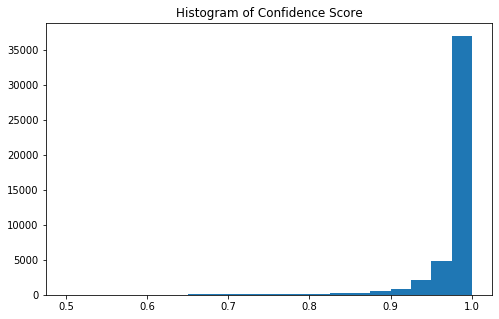

In [17]:
fig, ax = plt.subplots(1, figsize = (8, 5))

hist_data = p_scores.flatten().cpu().numpy()
ax.hist(hist_data, bins = 20)
ax.set_title('Histogram of Confidence Score');

### 4. Predicted Labels v.s. Target Labels

In [18]:
p_preds

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')

In [19]:
tgt_bbox, tgt_clas = b[1][3], b[2][3]
tgt_clas

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

### 4. Post-Processing on Target BBox and Target Labels

In [20]:
def unpad(tgt_bbox, tgt_clas, pad_idx=0):
    """
    changes:
    - all class labels decremented by 1 (padding label = -1)
    - bbox change from TLBR to CTHW format
    class labels for padding = -1
    """
    i = torch.min(torch.nonzero(tgt_clas-pad_idx))
    return tlbr2cthw(tgt_bbox[i:]), tgt_clas[i:]-1+pad_idx

In [21]:
tgt_bbox, tgt_clas = b[1][3], b[2][3]

# target class labels from one sample
tgt_clas.shape, tgt_bbox.shape, tgt_clas, tgt_bbox[:3]

(torch.Size([37]),
 torch.Size([37, 4]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([[ 0.8418, -0.0215,  0.9707,  0.2734],
         [ 0.4961,  0.9082,  0.6855,  1.0000],
         [ 0.5625,  0.2129,  0.6660,  0.3438]], device='cuda:0'))

In [22]:
unpad_tgt_bbox, unpad_tgt_clas = unpad(tgt_bbox, tgt_clas, pad_idx = 0)

unpad_tgt_clas.shape, unpad_tgt_bbox.shape, unpad_tgt_clas, unpad_tgt_bbox[:3]

(torch.Size([37]),
 torch.Size([37, 4]),
 tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1], device='cuda:0'),
 tensor([[0.9062, 0.1260, 0.1289, 0.2949],
         [0.5908, 0.9541, 0.1895, 0.0918],
         [0.6143, 0.2783, 0.1035, 0.1309]], device='cuda:0'))

In [23]:
unpad_tgt_clas

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1], device='cuda:0')

In [24]:
tgt_clas.shape, unpad_tgt_clas.shape

(torch.Size([37]), torch.Size([37]))

### 5. Sort scaled_bbox_pred in Descending Order of Scores

In [25]:
clas_pred.shape, p_scores.shape

(torch.Size([8, 46836, 1]), torch.Size([46584]))

In [26]:
p_scores

tensor([0.5151, 0.6707, 0.8492,  ..., 0.6807, 0.7549, 0.7480], device='cuda:0')

In [27]:
torch.argsort(p_scores, dim = -1, descending = True)

tensor([ 1876,  2164,  2163,  ...,     3,  9687, 46089], device='cuda:0')

### 6. Swap BBox from TLBR to LTRB
[y0, x0, y1, x1] --> [x0, y0, x1, y1]

In [62]:
tlbr_test = tlbr_bbox_pred[:4].clone()
tlbr_test

tensor([[-0.6725, -0.0475, -0.5150,  0.1100],
        [-0.5680, -0.0054, -0.3696,  0.1931],
        [-0.5680,  0.2445, -0.3696,  0.4430],
        [-0.3281,  0.3594, -0.2031,  0.4844]], device='cuda:0')

In [64]:
tlbr_test[:, [1, 0, 3, 2]]

tensor([[-0.0475, -0.6725,  0.1100, -0.5150],
        [-0.0054, -0.5680,  0.1931, -0.3696],
        [ 0.2445, -0.5680,  0.4430, -0.3696],
        [ 0.3594, -0.3281,  0.4844, -0.2031]], device='cuda:0')

### 7. Inteface mAP with Model Prediction

In [74]:
from src.metrics.mAP import calculate_image_precision

In [85]:
thresholds = [0.5, 0.55, 0.60, 0.65, 0.70]
b_mets = [] 
b_n = b[0].size(0)

for i in range(b_n):
    # filter and transform predicted bbox
    cthw_bbox_pred, scores, clas_pred = test_process_output(preds, i, detect_thresh = 0.5)
    keep_idxs = nms(cthw_bbox_pred, scores, thresh = 0.3)
    cthw_bbox_pred, scores, clas_pred = cthw_bbox_pred[keep_idxs], scores[keep_idxs], clas_pred[keep_idxs]
    tlbr_bbox_pred = cthw2tlbr(cthw_bbox_pred)
    sort_idxs = torch.argsort(scores, dim = -1, descending = True)
    tlbr_bbox_pred, scores, clas_pred = tlbr_bbox_pred[sort_idxs], scores[sort_idxs], clas_pred[sort_idxs]
    bbox_pred = tlbr_bbox_pred[:, [1, 0, 3, 2]]
    bbox_pred = bbox_pred.detach().cpu().numpy()
    bbox_pred = decode_bboxs(bbox_pred, img_size = 256)
    
    # clean target bbox
    tgt_bbox, tgt_clas = b[1][i], b[2][i]
    nonzero_idxs = torch.nonzero(tgt_clas)
    gts = tgt_bbox[nonzero_idxs].squeeze()
    gts = gts.detach().cpu().numpy()
    gts = decode_bboxs(gts, img_size = 256)
    
    mets = calculate_image_precision(gts, bbox_pred, thresholds, form = 'pascal_voc')
    b_mets.append(mets)
    
ans = sum(b_mets) / len(b_mets)
print(f'mAP = {ans}')

mAP = 0.001842771453017051


In [101]:
i, gts

(7,
 array([[125.75,  78.  , 144.  ,  97.  ],
        [140.75, 135.75, 168.  , 152.5 ],
        [149.5 , 110.75, 186.25, 142.75],
        [100.25, 157.5 , 113.  , 172.25],
        [240.  ,  26.75, 256.  ,  46.75],
        [112.  , 103.75, 133.75, 121.25],
        [177.  , 166.5 , 200.25, 183.  ],
        [184.  , 181.  , 206.  , 197.75],
        [ 99.  , 134.25, 123.  , 151.  ],
        [241.5 , 164.  , 256.  , 184.  ],
        [209.  ,  80.25, 237.25,  99.75],
        [  9.25, 235.75,  32.  , 252.25],
        [  0.  , 154.  ,  23.  , 170.5 ],
        [  0.  ,   0.  ,  14.75,  13.  ],
        [ 84.  , 120.75, 106.25, 138.  ],
        [ 97.  ,  91.25, 122.  , 112.25],
        [127.75, 134.5 , 146.5 , 148.75]], dtype=float32))

### 8. Recover BBox, Image as a Sanity Check (Plotting)

In [113]:
from matplotlib import patches, patheffects

In [112]:
def _draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

In [100]:
imgs, _, _ = dls.train.decode(b)

In [110]:
ck_img = PILImage.create(TensorImage(imgs[7]))
ck_gts = gts.copy()

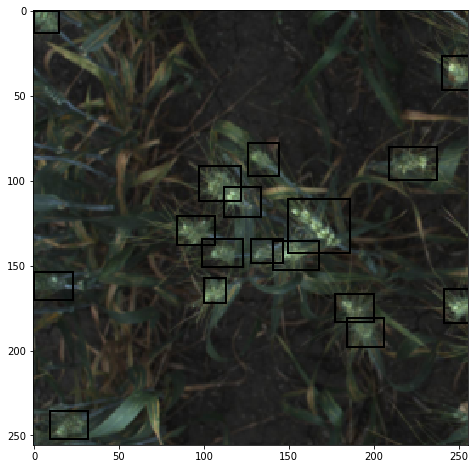

In [118]:
fig, ax = plt.subplots(1, figsize = (8, 8))
ax.imshow(ck_img)

for gt in ck_gts:
    x0, y0, x1, y1 = gt
    w = x1 - x0
    h = y1 - y0
    patch = ax.add_patch(patches.Rectangle((x0, y0), w, h, fill = False, lw = 2))